# Notebook 03 - Advanced Analysis
**Core Objective:** Extract deep-seated insights through model interpretability (SHAP) and unsupervised segmentation (Clustering/PCA).

This notebook moves beyond predictive accuracy to explore the "why" behind the data. It utilizes local and global explanation methods to interpret model behavior and employs clustering techniques to identify distinct participant profiles and intergenerational patterns.

**Key Technical Workflows:**
* **Model Interpretability (SHAP):** Implements SHAP (SHapley Additive exPlanations) to quantify feature contributions. Utilizes Beeswarm and Waterfall plots to visualize global importance and individual prediction drivers.
* **Unsupervised Segmentation:** Performs dimensionality reduction via **PCA** and executes **K-Means Clustering**. Determines optimal cluster count through the Elbow Method and validates results via PCA1 vs. PCA2 visualization.
* **Cluster Profiling:** Conducts a granular analysis of cluster traits, generating descriptive and visual profiles per predictor to define distinct cohort characteristics.
* **Intergenerational Analysis:** Segments findings by participant generation (Gen Z, Millennials, Gen X, etc.). Evaluates behavioral shifts across age cohorts using heatmaps and descriptive statistical comparisons.
* **Synthesis of Findings:** Integrates clustering quality assessments with verbal descriptions of discovered intergenerational patterns to provide actionable conclusions.

In [ ]:
# System and setup
from pathlib import Path
from utils.config import setup_notebook
import joblib

# Data handling
import numpy as np
import pandas as pd
from utils.data_io import load_data

# Visualization and styling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from utils.config import CLUSTER_COLORS

# Preprocessing and dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clustering and unsupervised learning
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans

# Model interpretation
import shap

# 2. Settings / Configuration

In [3]:
setup_notebook(seed=42)

# 3. Loading data and setup

## 3.1 Loading data

In [4]:
df_clean, clean_meta = load_data("../data/processed/clean_data.csv")

In [5]:
variables_info, var_meta = load_data("../data/metadata/variables_info.csv")

In [6]:
variables_info.head()

,Variable,Description
0,id,Unikalny identyfikator respondenta w bazie łąc...
1,intid,ID wywiadu
2,waga_proba,Waga próby bez korekty przypadków ekstremalnyc...
3,waga_proba_kor,Waga próby z korektą przypadków ekstremalnych ...
4,waga_pop,Waga populacyjna bez korekty przypadków ekstre...


In [7]:
df_clean.columns

Index(['id', 'wiek', 'm1', 'woj', 'm2', 'g8', 'wykszt_7k', 'j1_02', 'j1_03',
       'j1_04', 'j1_05', 'j1_06', 'j1_07', 'j1_08', 'j1_09', 'j1_10', 'j3_01',
       'j3_02', 'j3_03', 'j3_04', 'j3_05', 'j3_06', 'j3_07', 'j3_08', 'j3_09',
       'j3_10', 'j3_11', 'j3_12', 'j3_13', 'm9_13k', 'm9d', 'm13', 'o1_1',
       'o1_2', 'o1_3', 'j1_01', 'satisfaction', 'generation'],
      dtype='object')

## 3.2 Setup

In [8]:
models_path = Path("../models")

In [9]:
#Artifacts created in 03_modelling.ipynb
best_model = joblib.load(models_path / "best_model.pkl")
X_train_a_scaled = joblib.load(models_path / "X_train_a_scaled.pkl")
X_test_a_scaled = joblib.load(models_path / "X_test_a_scaled.pkl")
X_train_all = joblib.load(models_path / "X_train_all.pkl")
y_train = joblib.load(models_path / "y_train.pkl")

In [10]:
train_idx = joblib.load(models_path / "train_idx.pkl")

In [11]:
likert_predictors = [f"j1_{str(i).zfill(2)}" for i in range(1, 11)]
likert_predictors += [f"j3_{str(i).zfill(2)}" for i in range(1, 14)]
likert_predictors += ["m13"]  

# 4. Explainability & Analysis

## 4.1 SHAP

SHAP explainer created for the trained model - SHAP values computed for both training and test sets.

In [12]:
explainer = shap.Explainer(best_model, X_train_a_scaled)
shap_values_train = explainer(X_train_a_scaled)
shap_values_test = explainer(X_test_a_scaled)

In [13]:
description_lookup = dict(zip(variables_info["Variable"], variables_info["Description"]))
display_names = [
    f"{col} — {description_lookup.get(col, 'No description available')}" 
    for col in X_train_all.columns]

In [14]:
print(display_names)

['j1_01 — Zadowolenie: Zarobki', 'j1_02 — Zadowolenie: Możliwości awansu', 'j1_03 — Zadowolenie: Relacje z przełożonymi', 'j1_04 — Zadowolenie: Kontakty ze współpracownikami', 'j1_05 — Zadowolenie: Pewność zatrudnienia', 'j1_06 — Zadowolenie: Możliwość rozwoju osobistego i podnoszenia umiejętności', 'j1_07 — Zadowolenie: Możliwość łączenia pracy z życiem osobistym i innymi obowiązkami', 'j1_08 — Zadowolenie: Możliwość wykazania się inicjatywą i samodzielnością', 'j1_09 — Zadowolenie: Warunki wykonywania pracy', 'j1_10 — Zadowolenie: Z tego, co robi w pracy', 'j3_01 — Mam możliwość realizacji swoich własnych pomysłów', 'j3_02 — Czuję, że praca którą wykonuję, ma sens', 'j3_03 — Z chęcią zmieniłbym swoją pracę', 'j3_04 — W pracy muszę ciągle uczyć się nowych rzeczy', 'j3_05 — Czuję, że w pracy wykorzystuję swoją wiedzę i umiejętności', 'j3_06 — Często muszę wykonywać zadania, które są zbyt proste w stosunku do moich umiejętności', 'j3_07 — Czasem muszę wykonywać zadania, które są zbyt tr

A summary plot of SHAP values is generated for the test and training data to show which features contribute most to predictions.

#### SHAP summary – test data

This plot shows the global importance of features and the direction of their impact on the model output.

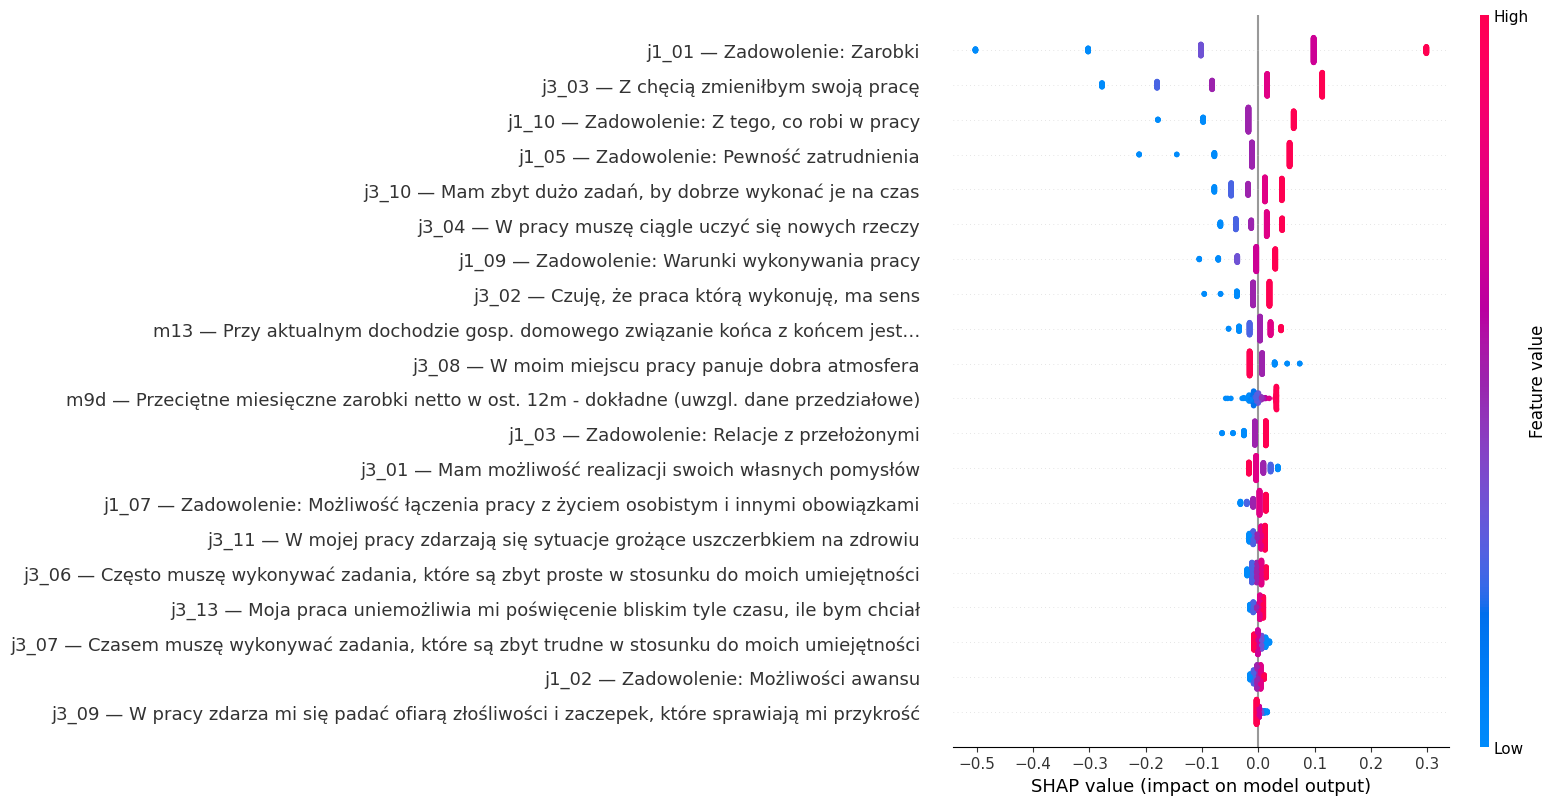

In [15]:
shap.summary_plot(
    shap_values_test, 
    X_test_a_scaled,
    feature_names = display_names,
    show=True 
)

From the graph, it can be observed that the variable with the strongest impact is personal satisfaction with earnings, measured on a 1-5 Likert scale. Interestingly, this factor is a stronger predictor than respondents’ actual income levels.

Two other strong positive predictors are satisfaction with one’s actual work tasks and employment security. The strongest negative predictor - unsurprisingly - is the desire to change jobs.

Among other notable predictors, a positive one is the need to continuously learn at work, while a negative one is having too many tasks to complete within deadlines.

#### SHAP summary – training data

This plot shows the global importance of features and the direction of their impact on the model output.

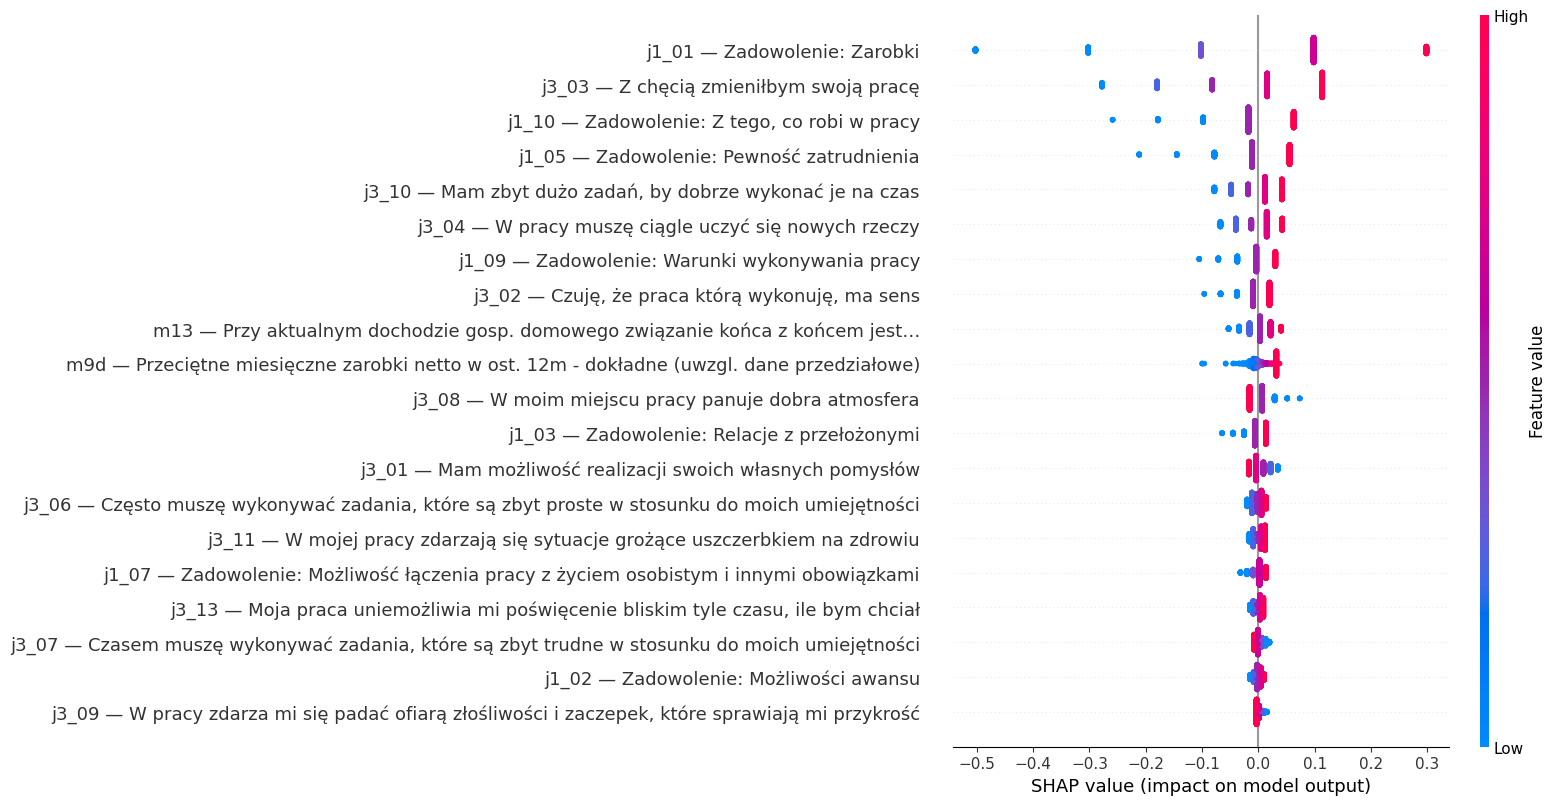

In [16]:
shap.summary_plot(
    shap_values_train, 
    X_train_a_scaled,
    feature_names = display_names 
)

The SHAP summary plots for train and test data look almost identical. To verify that the SHAP values were truly different, the correlation of mean absolute SHAP values per feature was calculated.

In [17]:
train_means = np.abs(shap_values_train.values).mean(axis=0)
test_means = np.abs(shap_values_test.values).mean(axis=0)
correlation = np.corrcoef(train_means, test_means)[0,1]

print("Correlation of mean absolute SHAP values (train vs test):", correlation)

Correlation of mean absolute SHAP values (train vs test): 0.9993966513604301


The correlation is extremely high (~0.999), which is expected for a linear model on standardized features.

#### SHAP waterfall - single instance

SHAP values are computed for a single test instance to interpret the model's prediction.

In [18]:
x_instance = pd.DataFrame(
    X_test_a_scaled[0].reshape(1, -1),
    columns=X_train_all.columns
)
shap_values_single = explainer(x_instance)

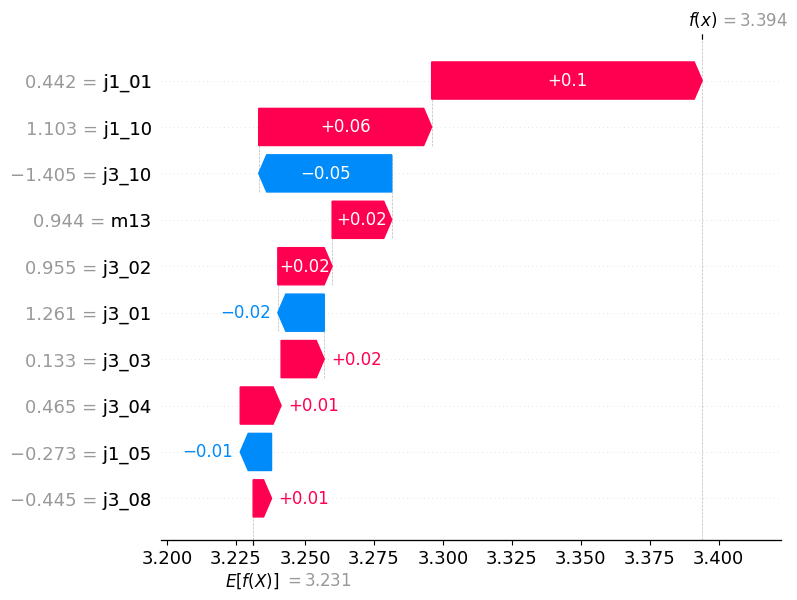

,Code,Description
0,j1_01,Zadowolenie: Zarobki
1,j1_10,"Zadowolenie: Z tego, co robi w pracy"
2,j3_10,"Mam zbyt dużo zadań, by dobrze wykonać je na czas"
3,m13,Przy aktualnym dochodzie gosp. domowego związa...
4,j3_02,"Czuję, że praca którą wykonuję, ma sens"
5,j3_01,Mam możliwość realizacji swoich własnych pomysłów
6,j3_03,Z chęcią zmieniłbym swoją pracę
7,j3_04,W pracy muszę ciągle uczyć się nowych rzeczy
8,j1_05,Zadowolenie: Pewność zatrudnienia
9,j3_08,W moim miejscu pracy panuje dobra atmosfera


In [19]:
top_idx = np.argsort(np.abs(shap_values_single.values[0]))[::-1][:10]
shap.plots.waterfall(shap_values_single[0][top_idx])

top_features = X_train_all.columns[top_idx]

feature_table = pd.DataFrame({
    "Code": top_features,
    "Description": [variables_info.loc[variables_info.Variable==c, "Description"].values[0] 
                    for c in top_features]
})

display(feature_table)

## 4.2 Clustering and PCA

### 4.2.1 Preparing SHAP values

PCA and clustering were performed on the training dataset (960 samples) because it provides a more stable estimate of variance and better representation of the data structure.

In [20]:
shap_values_df = pd.DataFrame(shap_values_train.values, columns=X_train_all.columns)
print(shap_values_df.isnull().values.any())

False


In [21]:
scaler = StandardScaler()
shap_scaled = scaler.fit_transform(shap_values_df)
print(shap_values_df)

        j1_01     j1_02     j1_03     j1_04     j1_05     j1_06     j1_07  \
0   -0.102080 -0.002194 -0.006216  0.002247 -0.011353 -0.001068  0.002034   
1    0.098077 -0.014733  0.013208  0.002247 -0.011353 -0.005176  0.013334   
2    0.098077  0.004075 -0.006216 -0.001766 -0.011353 -0.001068  0.002034   
3   -0.102080 -0.008463 -0.006216  0.002247  0.055430  0.003040 -0.009266   
4    0.098077  0.004075  0.013208  0.002247  0.055430 -0.001068  0.013334   
..        ...       ...       ...       ...       ...       ...       ...   
955  0.098077 -0.002194  0.013208  0.002247 -0.011353 -0.001068  0.002034   
956 -0.102080 -0.002194 -0.025639 -0.005779 -0.078137  0.003040 -0.009266   
957 -0.102080 -0.002194 -0.006216  0.002247 -0.078137 -0.001068  0.002034   
958 -0.102080 -0.002194  0.013208  0.002247  0.055430 -0.001068 -0.009266   
959  0.098077 -0.002194  0.013208 -0.001766 -0.011353 -0.001068  0.002034   

        j1_08     j1_09     j1_10  ...     j3_06     j3_07     j3_08  \
0  

### 4.2.2 Determining number of clusters

The elbow method is used to determine the optimal number of clusters by plotting inertia for k values from 2 to 9.

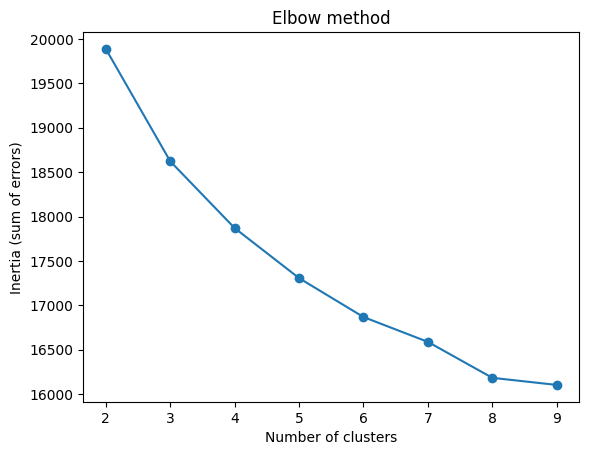

In [22]:
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(shap_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (sum of errors)')
plt.title('Elbow method')
plt.show()

KMeans clustering performed with k=7 clusters.

### 4.2.3 Clustering and PCA visualization

In [23]:
k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(shap_scaled)

shap_values_df['cluster'] = clusters

In [24]:
# Reducing dimensionality to 2D for plotting
pca = PCA(n_components=2)
shap_2d = pca.fit_transform(shap_scaled)

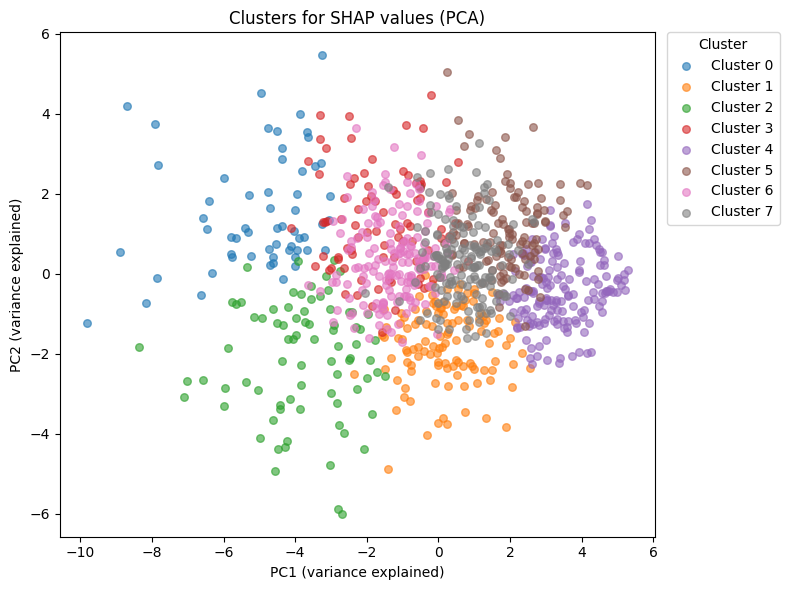

In [25]:
plt.figure(figsize=(8, 6))
for cluster_id, color in CLUSTER_COLORS.items():
    mask = clusters == cluster_id
    plt.scatter(
        shap_2d[mask, 0],
        shap_2d[mask, 1],
        color=color,
        label=f"Cluster {cluster_id}",
        alpha=0.6,
        s=30
    )
plt.title("Clusters for SHAP values (PCA)")
plt.xlabel("PC1 (variance explained)")
plt.ylabel("PC2 (variance explained)")
plt.legend(
    title="Cluster",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)
plt.tight_layout()
plt.show()

### 4.2.4 Cluster profiles

In [26]:
cluster_profiles = shap_values_df.groupby('cluster').mean()

In [27]:
shap_values_df['satisfaction'] = y_train.values

cluster_summary = shap_values_df.groupby('cluster')['satisfaction'].agg(['mean', 'std', 'count'])
print(cluster_summary)

             mean       std  count
cluster                           
0        2.689655  0.730462     58
1        3.214876  0.469159    121
2        2.734177  0.692614     79
3        2.976744  0.530854     86
4        3.591716  0.591751    169
5        3.532258  0.576441    124
6        3.116564  0.406622    163
7        3.393750  0.502783    160


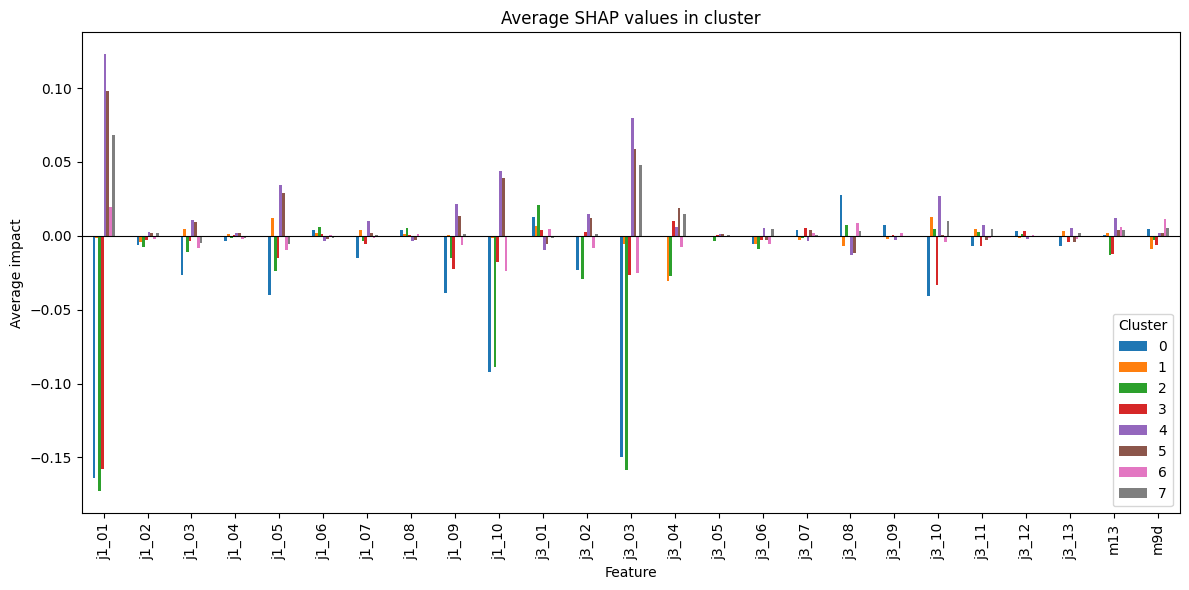

In [28]:
cluster_profiles.T.plot(kind='bar', figsize=(12, 6))
plt.title("Average SHAP values in cluster")
plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Feature")
plt.ylabel("Average impact") 
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

### 4.2.5 Cluster-wise SHAP plots

Color-coded bar plots are generated for each cluster to visualize the average SHAP values per feature.  
Positive contributions are shown in red, negative contributions in blue.

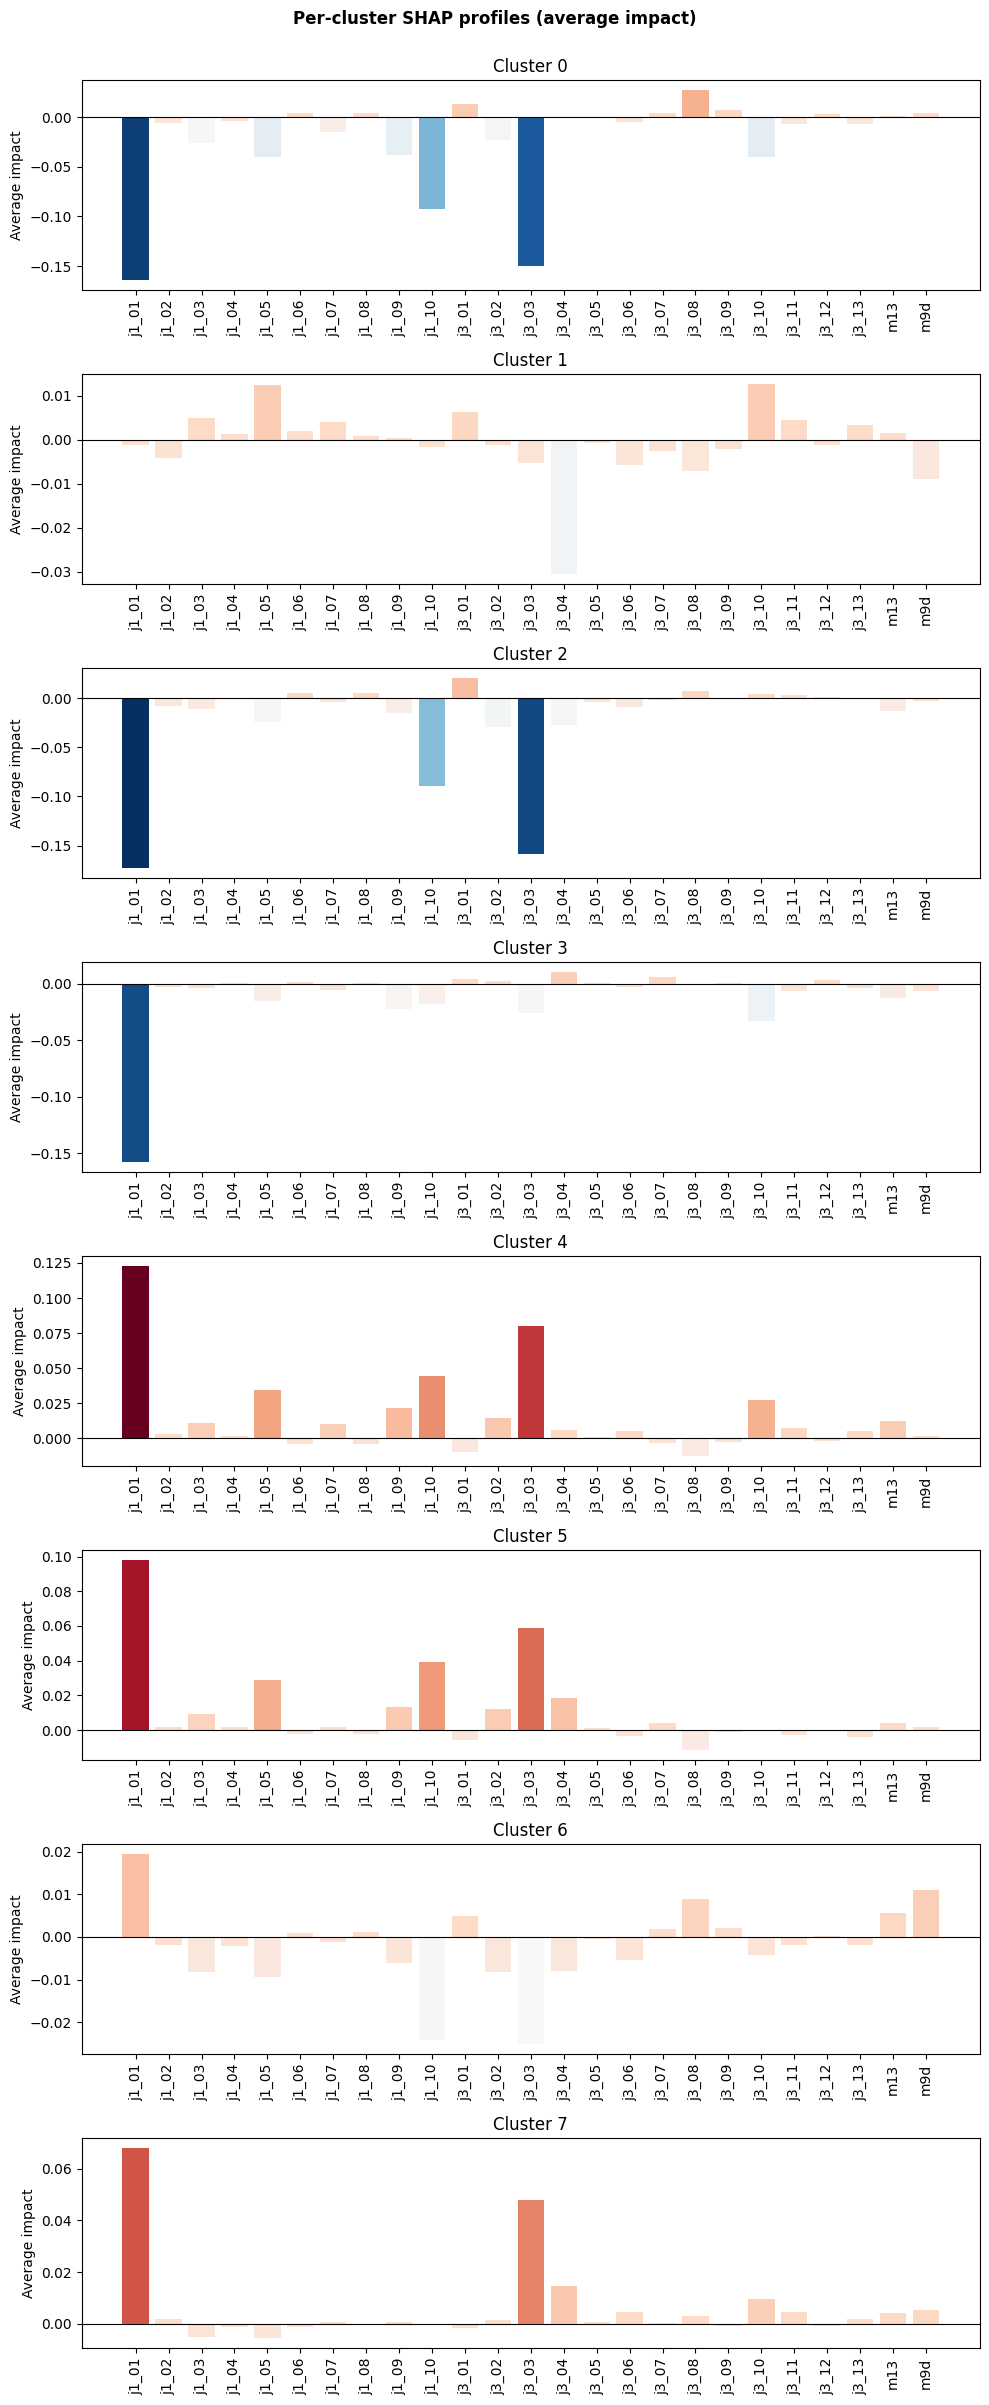

In [29]:
clusters_sorted = sorted(shap_values_df['cluster'].unique())

cmap = cm.get_cmap('RdBu_r')  # reversed so red=positive, blue=negative
vmax = cluster_profiles.values.max()
vmin = cluster_profiles.values.min()

fig, axes = plt.subplots(nrows=len(clusters_sorted), figsize=(10, 3 * len(clusters_sorted)))

for i, cluster_id in enumerate(clusters_sorted):
    ax = axes[i]
    vals = cluster_profiles.loc[cluster_id]
    colors = [cmap((v - vmin) / (vmax - vmin)) for v in vals.values]
    ax.bar(vals.index, vals.values, color=colors)
    ax.axhline(0, color='black', linewidth=0.8)
    fig.suptitle("Per-cluster SHAP profiles (average impact)", fontweight="bold", y=1)
    ax.set_title(f"Cluster {cluster_id}")
    ax.set_ylabel("Average impact")
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### 4.2.6 Assessing the quality of clusterization

In [30]:
ch = calinski_harabasz_score(shap_scaled, clusters)
db = davies_bouldin_score(shap_scaled, clusters)

print(f"Calinski-Harabasz: {ch:.2f}")
print(f"Davies-Bouldin: {db:.2f}")

Calinski-Harabasz: 65.68
Davies-Bouldin: 2.76


The clustering exhibits moderate separation between groups.  
The Calinski-Harabasz index of 65.68 suggests reasonably distinct clusters, while the Davies-Bouldin index of 2.76 indicates some overlap between clusters.  
Overall, the clusters are acceptable for exploratory analysis of SHAP-based feature patterns.

### 4.2.7 Cluster-Level Analysis of Job Satisfaction (Based on SHAP Values)

| Cluster | Mean Satisfaction | Std. Dev. | n   | Summary Description |
|:------:|:-----------------:|:---------:|:---:|:--------------------|
| **4 (Secure & Highly Satisfied)** | **3.59** | 0.59 | 169 | *The “Securely Satisfied Core.”* Highest overall satisfaction. Strongest positive impact from **earnings satisfaction (j1_01)**, **unwillingness to change jobs (j3_03, rev.)**, and **liking what they do (j1_10)**. Also benefit from **job stability (j1_05)** and **manageable workload (j3_10, rev.)**. Satisfaction is strongly anchored in material security and role fit. |
| **5 (Growth-Oriented Satisfied)** | **3.53** | 0.58 | 124 | *The “Growth-Positive Satisfied.”* Second-highest satisfaction. Similar drivers to Cluster 4 (pay, stability, job fit) but uniquely shows the **strongest positive impact from learning new things (j3_04)**. Less sensitive to workload pressure. Indicates satisfaction through development rather than comfort alone. |
| **7 (Balanced & Comfortable)** | **3.39** | 0.50 | 160 | *The “Balanced Satisfied.”* High satisfaction driven primarily by **earnings (j1_01)** and **job retention (j3_03, rev.)**, with secondary positives from **learning (j3_04)** and **lack of overload (j3_10, rev.)**. Minimal negative predictors. Satisfaction is broad but not deeply tied to intrinsic job meaning. |
| **6 (Financially Anchored Neutral)** | **3.12** | 0.41 | 163 | *The “Materially Anchored Neutral.”* Moderate satisfaction with **actual income (m9d)** and **pay satisfaction (j1_01)** as the dominant positives. Also benefits from **good atmosphere (j3_08)** and **financial ease (m13)**. Other job-quality features show weak or negative effects, indicating a primarily financial orientation. |
| **1 (Comfort-Seeking Disengaged)** | **3.21** | 0.46 | 121 | *The “Unbothered / Comfort-Seeking.”* Neutral-to-mild satisfaction with very small feature impacts overall. Most notable negative is **learning new things (j3_04)**, suggesting aversion to novelty. Mild positives from **job stability (j1_05)** and **manageable workload (j3_10, rev.)**. Generally disengaged but content with predictability. |
| **3 (Pay-Frustrated Dissatisfied)** | **2.98** | 0.53 | 86  | *The “Compensation-Frustrated.”* Dissatisfaction is driven primarily by **earnings satisfaction (j1_01)**. Mild negative impact from **task overload (j3_10)** and **willingness to change jobs (j3_03)** suggests fewer structural constraints than other dissatisfied clusters. Slight positive from **learning (j3_04)**. |
| **2 (Structurally Constrained Dissatisfied)** | **2.73** | 0.69 | 79  | *The “Constrained & Unhappy.”* Low satisfaction despite relatively better pay levels. Negative impacts from **job retention (j3_03, rev.)** and **overload tolerance (j3_10, rev.)** indicate structural or psychological constraints. Pay and meaning do not compensate for dissatisfaction. |
| **0 (Diffuse Dissatisfied)** | **2.69** | 0.73 | 87  | *The “Broadly Dissatisfied.”* Lowest satisfaction with diffuse, weakly distributed negative impacts across features. Particularly insensitive to improvement levers. Shows tolerance for workload pressure (**j3_10, rev.**) but lacks strong positive drivers, suggesting generalized disengagement rather than a single pain point. |

#### Key Patterns & Interpretations

- **Compensated / Constrained Dissatisfaction (Clusters 0, 2, 3):** These clusters show **negative SHAP impacts from earnings satisfaction (j1_01)** and, to varying degrees, **retention intent (j3_03)**. Higher pay or perceived financial security does *not* translate into higher job satisfaction, suggesting forms of **constraint, trade-off, or entrapment** rather than engagement.  
  - Cluster 0: diffuse dissatisfaction with weak positive levers  
  - Cluster 2: strongest structural constraints (pay & meaning inversions)  
  - Cluster 3: dissatisfaction most clearly centered on compensation
- **Financially Anchored Satisfaction (Clusters 4, 5, 6, 7):**  
  For these clusters, satisfaction is **positively driven by financial factors**, though with meaningful variation:  
  - **Cluster 4**: strongest alignment of pay, stability, task fit, and retention  
  - **Cluster 5**: similar profile but with added sensitivity to learning and growth  
  - **Cluster 6**: satisfaction most tightly coupled to **actual income (m9d)** and financial comfort  
  - **Cluster 7**: balanced profile where pay matters, but not exclusively
- **Learning & Growth as a Differentiator (Not a Universal Driver):**  
  Attitudes toward learning clearly separate clusters:  
  - **Positive impact**: Cluster 5 and Cluster 7 (growth-supportive satisfaction)  
  - **Negative impact**: Cluster 1 and Cluster 2 (learning as friction rather than enrichment)  
  - **Near-neutral**: Cluster 4 and Cluster 6 (learning is acceptable but not central)
- **Atmosphere, Autonomy, and “Soft” Factors:**  
  Contrary to intuition, *good atmosphere* (j3_08) and *autonomy* (j3_01) are **not universal positives**:  
  - They show **neutral or negative SHAP impact** in the most satisfied clusters (4 and 5), implying satisfaction there is driven more by **structure and security** than by social or creative factors.  
  - Their positive role is limited and context-dependent, rather than broadly explanatory.


#### Notable SHAP Insight Example
> *For clusters 0, 2, and 3, satisfaction with earnings (j1_01) has a significant inverse relationship with overall job satisfaction. This suggests a “compensated dissatisfaction” dynamic where higher pay acts as a stabilizing constraint rather than a source of engagement — employees remain despite dissatisfaction, not because of satisfaction.*


#### Overall Summary

Across the eight clusters, job satisfaction resolves into **three dominant patterns**:

1. **Financially anchored satisfaction**  
   *(Clusters 4, 5, 6, 7)*  
   Satisfaction increases with pay, stability, and financial comfort, though growth and workload tolerance vary.

2. **Structurally constrained dissatisfaction**  
   *(Clusters 0, 2, 3)*  
   Higher pay, security, or meaning do not alleviate dissatisfaction and may even coincide with it, pointing to trade-offs or limited mobility.

3. **Low-sensitivity / disengaged neutrality**  
   *(Cluster 1)*  
   Overall satisfaction is relatively stable and weakly affected by most features, suggesting disengagement rather than active dissatisfaction or fulfillment.

**Taken together, the results show that job satisfaction is not driven by a single set of universal levers.**  
The same factors — pay, meaning, learning, atmosphere — can act as **drivers, constraints, or noise**, depending on the employee profile.

### 4.2.8 Cluster Demographics

In [ ]:
demo_cols = ['wiek', 'm1', 'generation', 'woj', 'm2', 'g8', 'wykszt_7k', 'm9d', 'satisfaction']

df_demographics = df_clean.loc[train_idx, demo_cols].copy()

df_demographics['cluster'] = clusters

In [47]:
# Aggregate demographics by cluster
cluster_profiles = df_demographics.groupby('cluster').agg({
    'wiek': ['mean', 'median'],
    'm9d': ['mean', 'median', lambda x: x.quantile(0.75)],
    'satisfaction': 'mean',
})

print(cluster_profiles)

              wiek                  m9d                       satisfaction
              mean median          mean  median    <lambda_0>         mean
cluster                                                                   
0        43.896552   45.5   9190.324452  3775.0  22226.726517     2.689655
1        40.917355   39.0   4190.865653  3000.0   3500.000000     3.214876
2        39.367089   39.0   6240.666095  3000.0   4750.000000     2.734177
3        47.000000   49.0   4531.687766  3100.0   4000.000000     2.976744
4        40.461538   39.0   7146.452473  3900.0   7500.000000     3.591716
5        41.991935   41.5   6873.820186  4150.0   6500.000000     3.532258
6        43.073620   42.0  11724.375838  6500.0  22458.202901     3.116564
7        40.300000   40.0   8616.361854  4900.0   8875.000000     3.393750


#### Cluster Demographics Summary

| Cluster | Mean Age | Median Age | Mean Income (m9d) | Median Income (m9d) | Income Std. Dev. | Mean Satisfaction |
|:------:|:--------:|:----------:|:-----------------:|:-------------------:|:----------------:|:-----------------:|
| 0 | 43.9 | 45.5 | 9,190 | 3,775 | 9,041 | 2.69 |
| 1 | 40.9 | 39.0 | 4,191 | 3,000 | 4,938 | 3.21 |
| 2 | 39.4 | 39.0 | 6,241 | 3,000 | 7,383 | 2.73 |
| 3 | 47.0 | 49.0 | 4,532 | 3,100 | 5,068 | 2.98 |
| 4 | 40.5 | 39.0 | 7,146 | 3,900 | 6,846 | 3.59 |
| 5 | 42.0 | 41.5 | 6,874 | 4,150 | 6,456 | 3.53 |
| 6 | 43.1 | 42.0 | 11,724 | 6,500 | 9,165 | 3.12 |
| 7 | 40.3 | 40.0 | 8,616 | 4,900 | 7,908 | 3.39 |

## Demographic Insights & Interpretation

- **Age and satisfaction show a weak but consistent relationship.**  
  The least satisfied clusters (0 and 3) are also among the oldest, suggesting that dissatisfaction in these groups may reflect longer-term constraints or accumulated trade-offs rather than early-career instability.  
  **Cluster 2 is a notable exception**: despite being the youngest cluster, it remains strongly dissatisfied, reinforcing the interpretation of *structural misalignment* rather than age-related effects.

- **Income level alone does not determine job satisfaction.**  
  The three highest-earning clusters exhibit markedly different satisfaction profiles:
  - **Cluster 6**: highest earners, but only neutral satisfaction  
  - **Cluster 0**: high mean income, yet low satisfaction  
  - **Cluster 7**: high income paired with high satisfaction  
  This divergence supports the SHAP findings that compensation can act as a stabilizer or constraint rather than a universal motivator.

- **Income dispersion is more informative than income level.**  
  Clusters with the largest income standard deviations (notably 0 and 6) show weaker or negative satisfaction outcomes, while clusters with higher median income and more moderate dispersion (4, 5, 7) tend to be more satisfied.  
  This suggests that **predictability and perceived fairness of earnings** may matter more than absolute income.

- **Demographics reinforce, rather than replace, feature-based explanations.**  
  Age and earnings contextualize cluster differences but do not fully explain them. The demographic patterns align closely with the SHAP-based interpretations, strengthening confidence that the identified drivers reflect genuine structural differences rather than demographic artifacts.

Overall, the demographic analysis complements the feature importance results, confirming that job satisfaction emerges from a combination of financial structure, perceived constraints, and role alignment — not from income or age alone.

### 4.2.9 Assessing intergenerational differences

In [32]:
# Average satisfaction
predictor_cols_for_avg = likert_predictors + ['satisfaction']
avg_satisfaction_by_generation = df_clean.groupby('generation')[predictor_cols_for_avg].mean().reindex(['BB', 'X', 'M', 'Z', 'A'])
print("\nAverage satisfaction, by generation:")
print(avg_satisfaction_by_generation)


Average satisfaction, by generation:
               j1_01     j1_02     j1_03     j1_04     j1_05     j1_06  \
generation                                                               
BB          3.403846  2.980769  4.237179  4.435897  4.352564  3.653846   
X           3.422472  3.080899  4.249438  4.408989  4.155056  3.698876   
M           3.700000  3.254545  4.218182  4.415909  4.263636  3.720455   
Z           3.825000  3.350000  4.406250  4.562500  4.262500  3.843750   
A                NaN       NaN       NaN       NaN       NaN       NaN   

               j1_07     j1_08     j1_09     j1_10  ...     j3_06     j3_07  \
generation                                          ...                       
BB          3.839744  3.993590  4.025641  4.237179  ...  2.967949  3.794872   
X           3.892135  4.002247  4.031461  4.134831  ...  3.224719  3.741573   
M           3.900000  4.040909  4.118182  4.127273  ...  3.165909  3.743182   
Z           3.843750  4.100000  4.218750  4.2437

In [33]:
avg_satisfaction_by_generation.head()

,j1_01,j1_02,j1_03,j1_04,j1_05,j1_06,j1_07,j1_08,j1_09,j1_10,...,j3_06,j3_07,j3_08,j3_09,j3_10,j3_11,j3_12,j3_13,m13,satisfaction
generation,,,,,,,,,,,,,,,,,,,,,
BB,3.403846,2.980769,4.237179,4.435897,4.352564,3.653846,3.839744,3.993590,4.025641,4.237179,...,2.967949,3.794872,4.339744,4.217949,3.692308,3.339744,3.467949,3.583333,3.903846,3.192308
X,3.422472,3.080899,4.249438,4.408989,4.155056,3.698876,3.892135,4.002247,4.031461,4.134831,...,3.224719,3.741573,4.312360,4.339326,3.669663,3.368539,3.516854,3.485393,3.829213,3.231461
M,3.700000,3.254545,4.218182,4.415909,4.263636,3.720455,3.900000,4.040909,4.118182,4.127273,...,3.165909,3.743182,4.293182,4.327273,3.640909,3.581818,3.763636,3.572727,4.038636,3.261364
Z,3.825000,3.350000,4.406250,4.562500,4.262500,3.843750,3.843750,4.100000,4.218750,4.243750,...,3.125000,3.756250,4.456250,4.525000,3.687500,3.718750,4.025000,3.687500,4.200000,3.287500
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Dropping Gen A due to missing data
avg_satisfaction_by_generation_clean = avg_satisfaction_by_generation.drop(index='A')

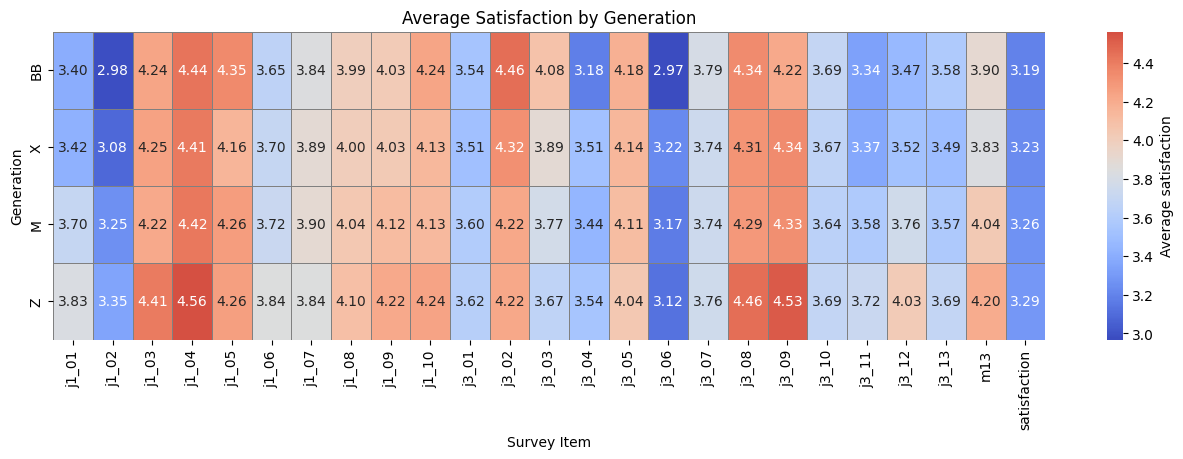

In [35]:
plt.figure(figsize=(16, 4))

sns.heatmap(
    avg_satisfaction_by_generation_clean,      
    annot=True,                          
    fmt=".2f",                           
    cmap="coolwarm",                     
    linewidths=0.5,
    linecolor="gray",
    center=avg_satisfaction_by_generation_clean.values.mean(),
    cbar_kws={'label': 'Average satisfaction'}
)

plt.title("Average Satisfaction by Generation")
plt.xlabel("Survey Item")
plt.ylabel("Generation")
plt.show()

**Generational Patterns in Satisfaction**

Gen Z tends to report the highest satisfaction across most aspects, while Baby Boomers generally show the lowest.  
It’s hard to tell whether this difference comes from age itself or from generational attitudes.

**Variables with the lowest average satisfaction**
- **j3_06** - Feeling that tasks are too easy for one’s skillset.  
- **j1_02** - Opportunities for promotion.  
- **Overall job satisfaction.**


**Variables with the highest average satisfaction**
- **m13** - Ability to make ends meet with household income.  
- **j1_04** - Relations with coworkers.  
- **j3_09** - Lack of workplace harassment.

Millennials report finding it easiest to make ends meet among all generations.


**Notable cross-generational patterns**
- For many variables, **Gen X scores slightly lower** than both Baby Boomers and Millennials - e.g.:
  - **Job stability (j1_05)**
  - **Ability to spend enough time with loved ones (j3_13)**


- Reverse trend for **j3_04** (learning new things at work):  
  Gen X is *more satisfied* with opportunities to learn, and also feels *less underchallenged* by simple tasks (**j3_06**) than other generations.


- **Reverse satisfaction trends** (Baby Boomers most satisfied, younger generations less):  
  - Job stability (**j1_05**)  
  - Feeling work has meaning (**j3_02**)  
  - Lack of willingness to change jobs (**j3_03**)  
  - Utilizing knowledge and skills (**j3_05**)
  

**Largest intergenerational differences**
- **m13** - Ease of making ends meet: big leap between Millennials (highest) and Gen X, and another between Gen X and Baby Boomers.  
- **j3_06** - Tasks too easy for skillset: Baby Boomers feel their skills are most underutilized.  
- **j1_02** - Opportunities for promotion: Baby Boomers feel most “stuck.”  
- **j3_04** - Needing to learn new things at work: increase from Baby Boomers to Gen X.  
- **j3_12** - Work’s negative health impact: strong increases between Gen X → Millennials → Gen Z.  
- **j3_09** - Workplace harassment: Gen Z reports the least, notably less than Millennials.